# Correlation between Coronavirus (COVID-19) Vaccinations and Excess Mortality in the OWID Dataset

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

## Get and Process the Data
We get the data from OWID and interpolate/upsample the missing values weekly.   

In [2]:
d=pd.read_excel('https://covid.ourworldindata.org/data/owid-covid-data.xlsx')

### Filter Out Countries With Insufficient Data
If there is no single row with both Vaccinations and Excess Mortality data we have nothing to work with. So we filter such countries out completely.

In [3]:
country_corr=d.groupby('iso_code')[
    ['excess_mortality','total_vaccinations_per_hundred']
                                  ].corr().unstack().iloc[:,1].reset_index()

country_corr.columns=['iso_code','correlation']

countries_worth_looking_at=list(
    country_corr[~country_corr['correlation'].isna()]
    .sort_values(
        'correlation'
        ,ascending=False
    )['iso_code']
)

dfc = d[(d['iso_code'].isin(countries_worth_looking_at))].copy()

### Interpolate The Data By Backfilling
Some countries have the data reported monthly while others have missing data points. We resample everything to the weekly grane and interpolate via backfilling. This way the vaccination time series before the start of reporting are backfilled with a static value (first value in time serie), mostly close to zero. This makes the year 2020 kind of a synthetic control in regard to the vaccination treatment. 

In [4]:
# resample needs datetime index
dfc['datetime'] = pd.to_datetime(dfc['date'])
dfc.index = dfc['datetime']
del dfc['datetime']

# we use the mean() function to fill the missing values with the NAs
dfi=dfc.groupby('iso_code').resample('W').mean().reset_index()
dfi.index = pd.to_datetime(dfi['datetime'])
del dfi['datetime']

# interpolation within countries
for i in range(len(dfi.iso_code.unique())):
    mask = dfi.loc[:,'iso_code']==dfi.iso_code.unique()[i]
    dfi[mask]=dfi[mask].interpolate(method='bfill')
dfi.reset_index(inplace=True)

# Overall Correlation between Vaccinations and Excess Mortality

In [5]:
print('Correlation total_vaccinations_per_hundred and excess_mortality ='
      ,'\x1b[1;30;30m{:.2f}\x1b[m'.format(
    dfi[['excess_mortality', 'total_vaccinations_per_hundred']].corr().unstack()[1])) 

Correlation total_vaccinations_per_hundred and excess_mortality = -0.04


At the moment of writing the correlation is close to zero (-0.04). Let's de-average the overal value by calculating the correlation per country.  

## De-averaging Of The Correlation By Country
We chart correlation between excess_mortality and total_vaccinations_per_hundred (and other vaccination metrics) per country to make sure the data is sane.

The Choropleth Charts give an idea how the correlation is distibuted over the globe. May be there is some role the seasonality plays in the resulting in-country corellation.

The Histograms show that the in-country correlation is kinda evenly distributed over the whole [-1:1] interval and there are no visible ouliers.

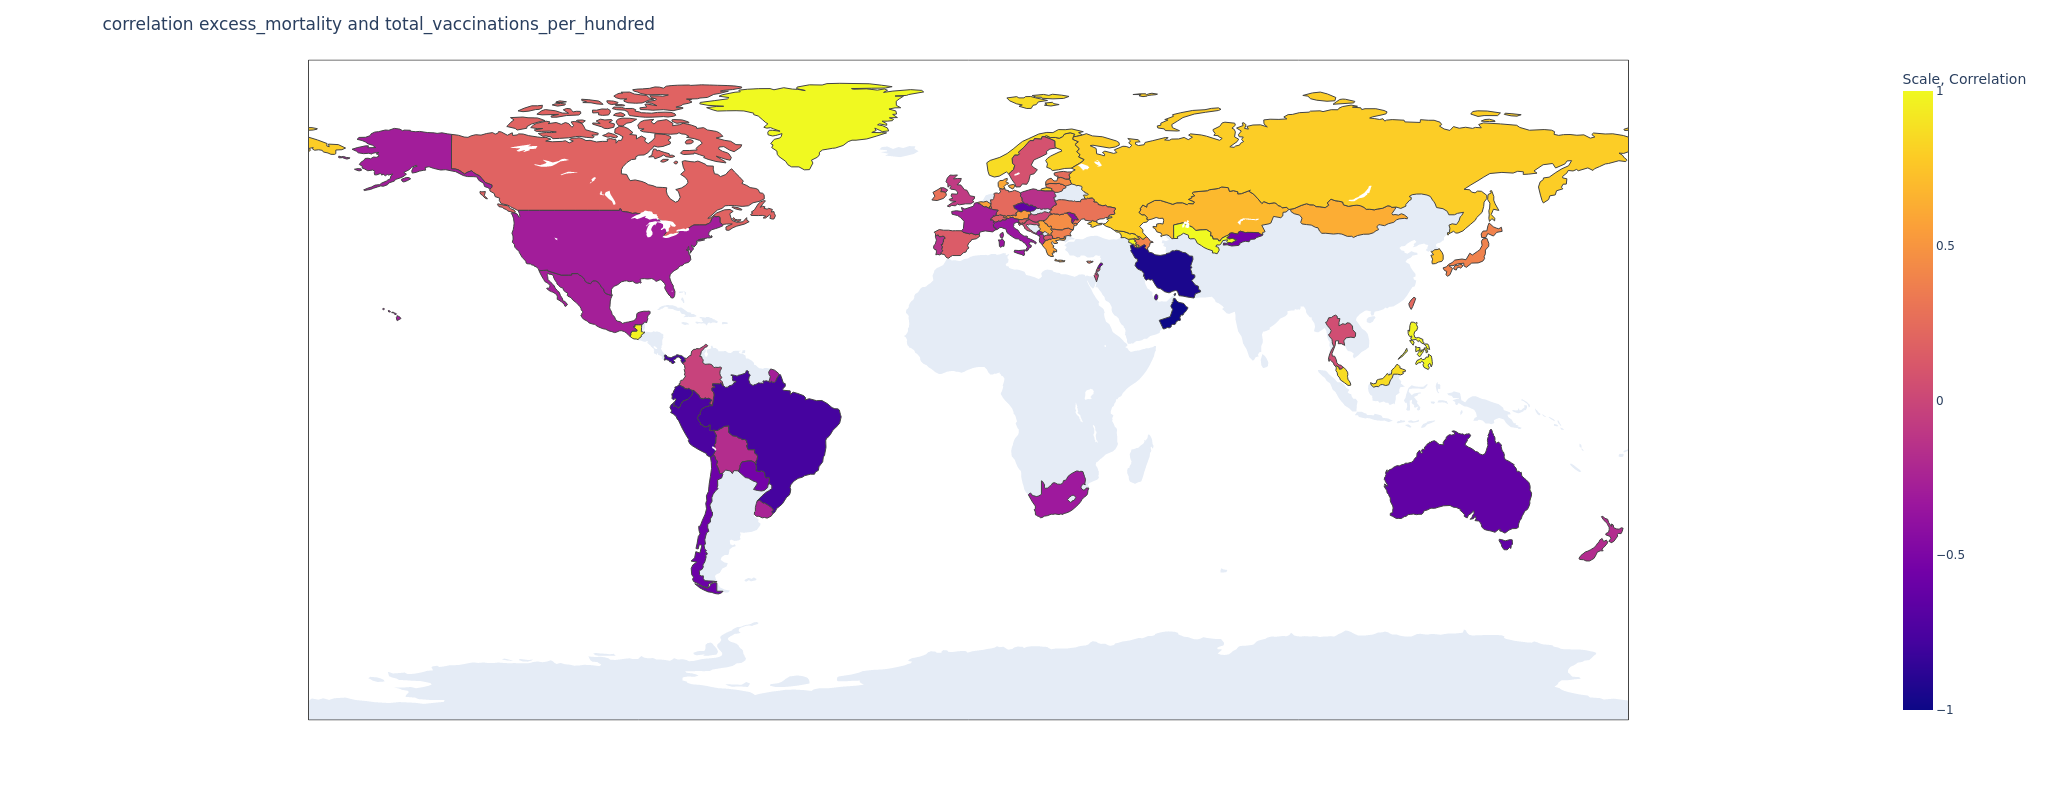

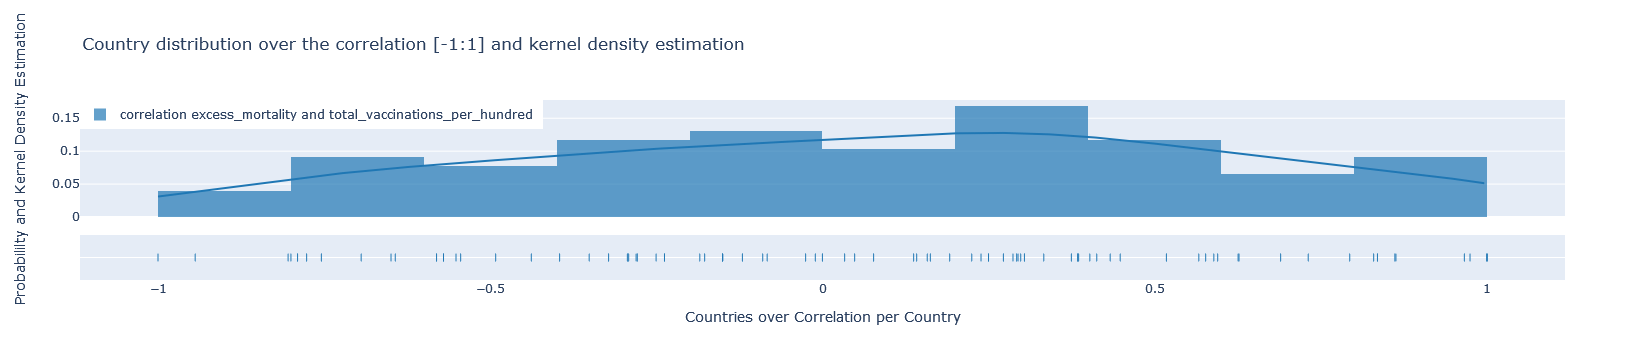

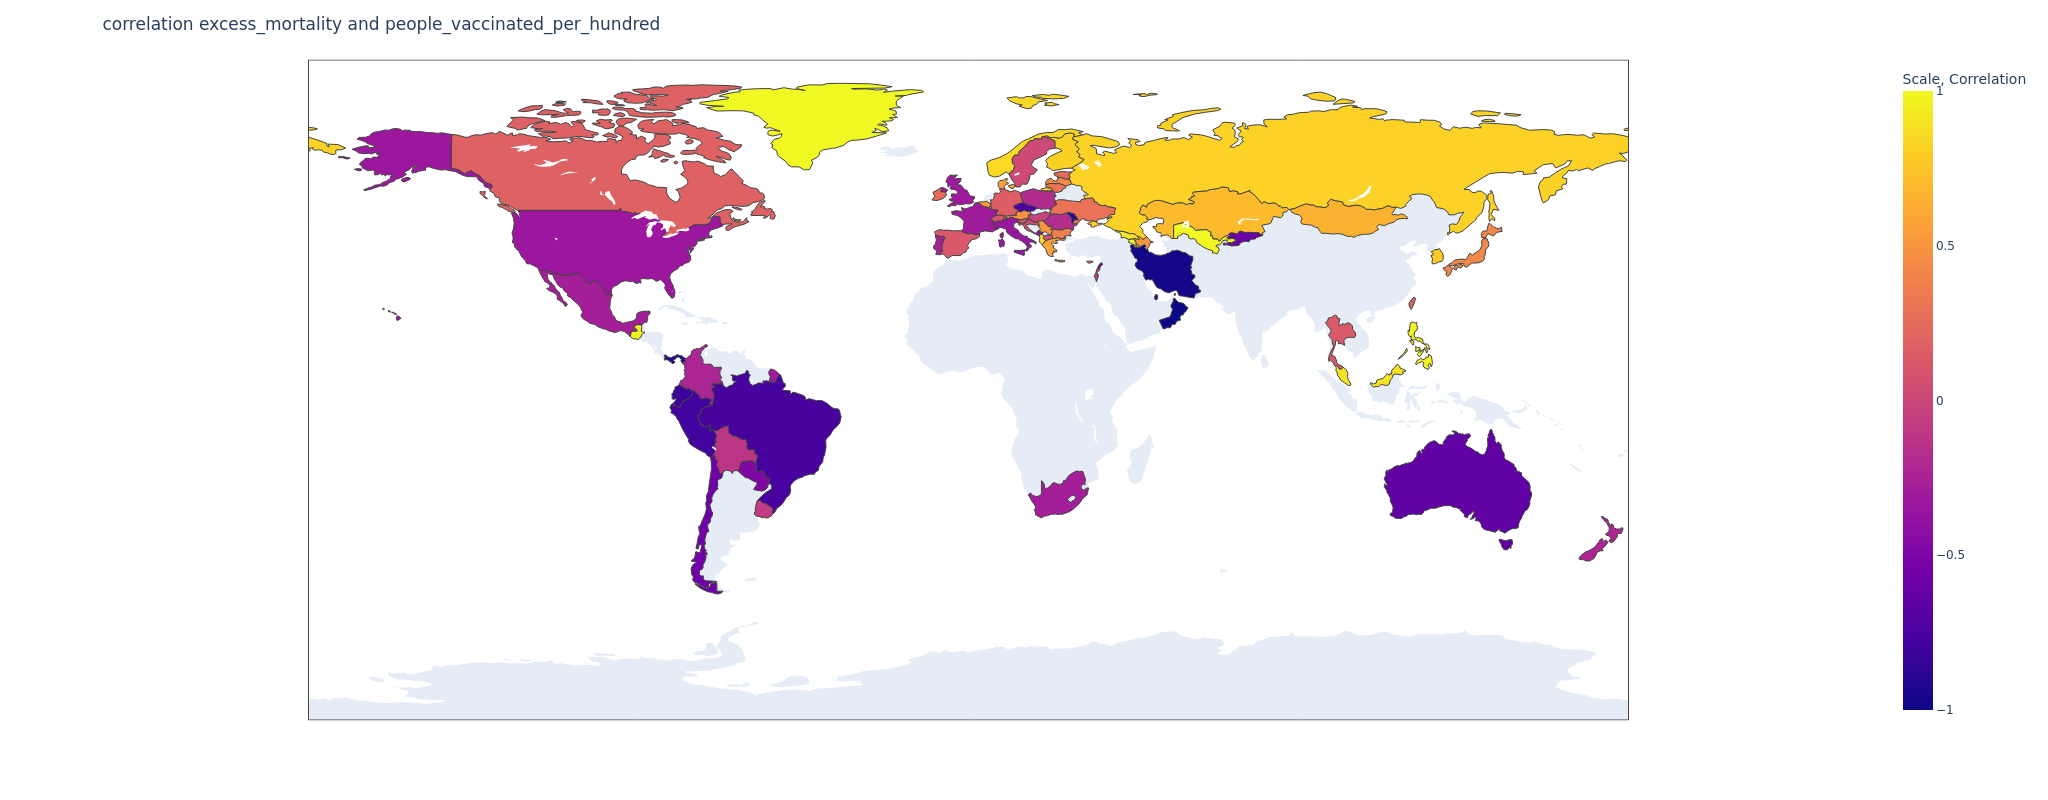

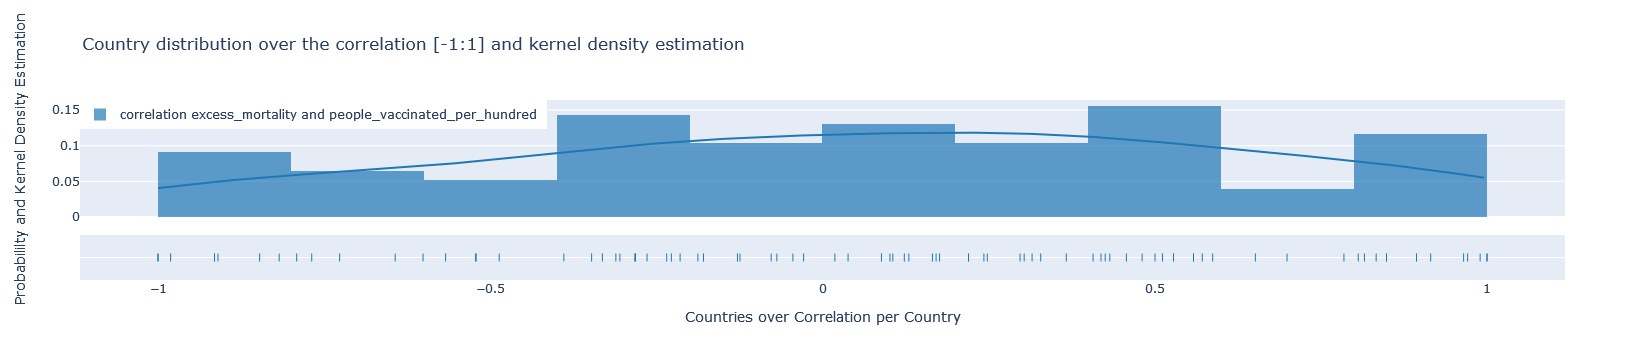

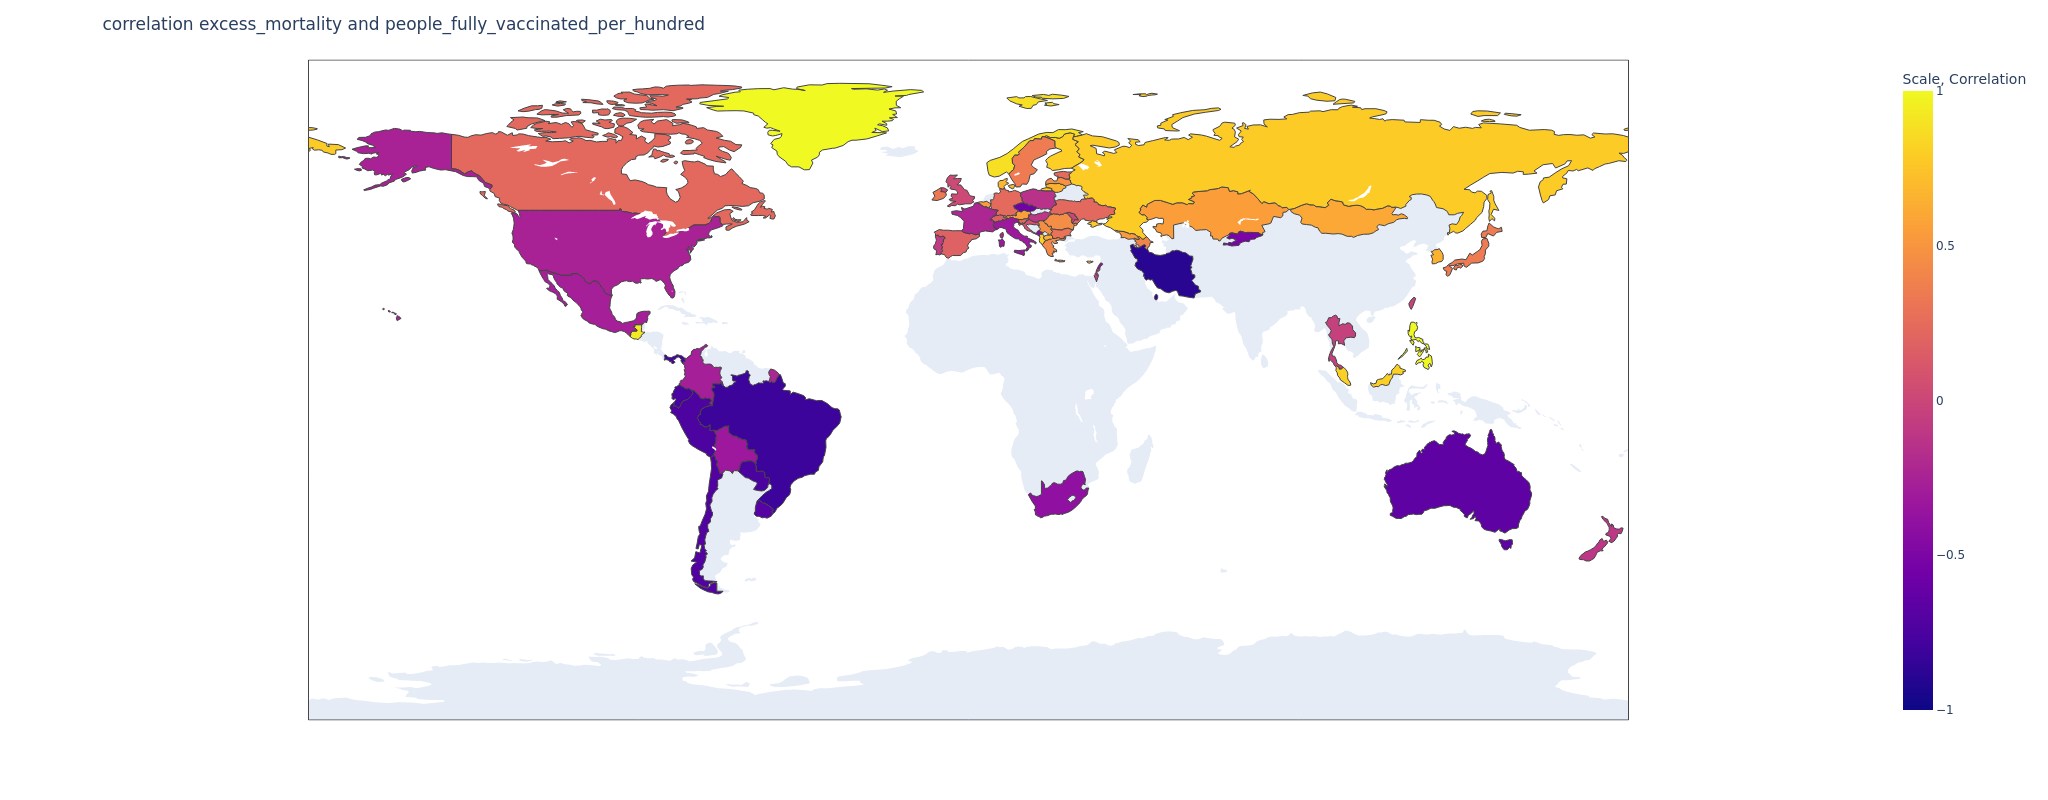

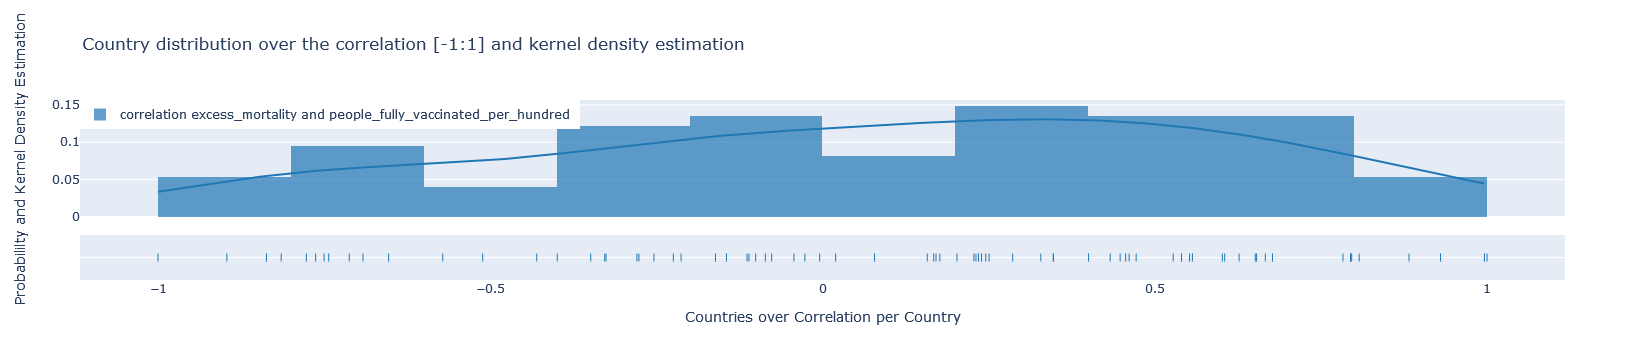

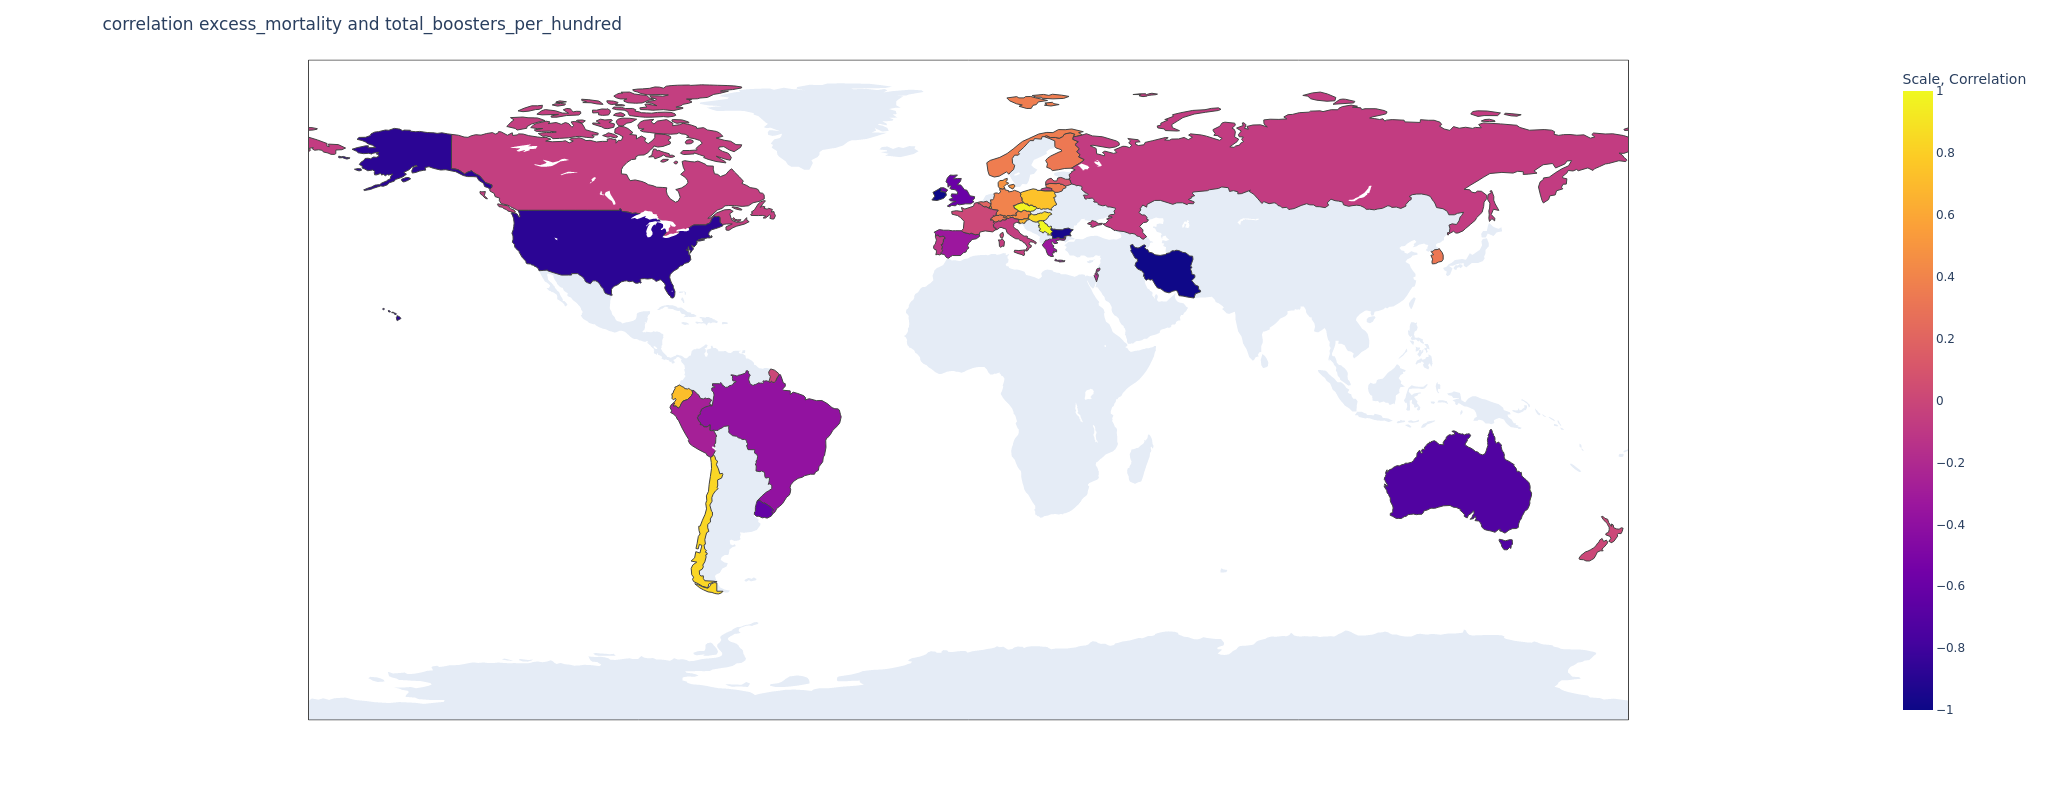

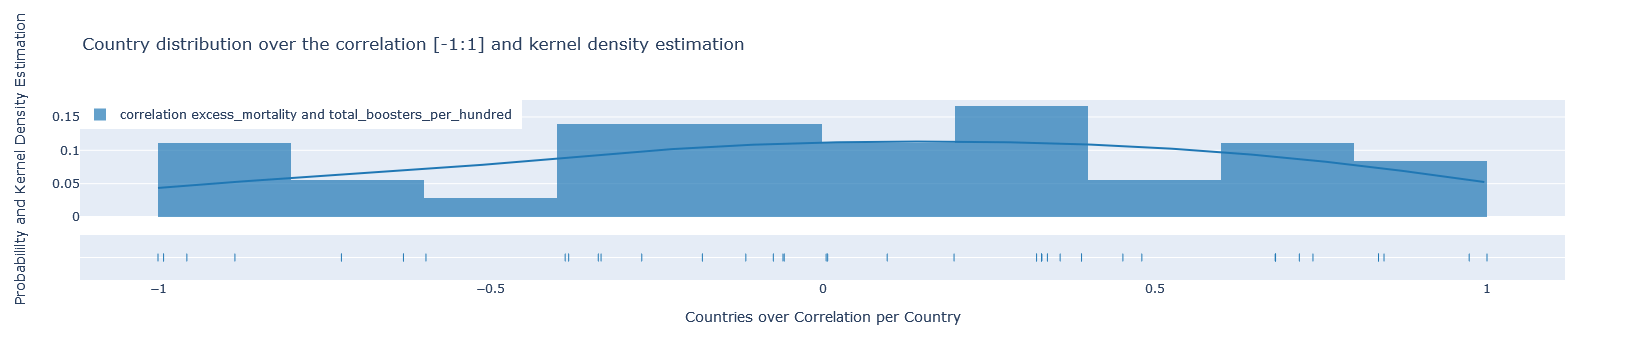

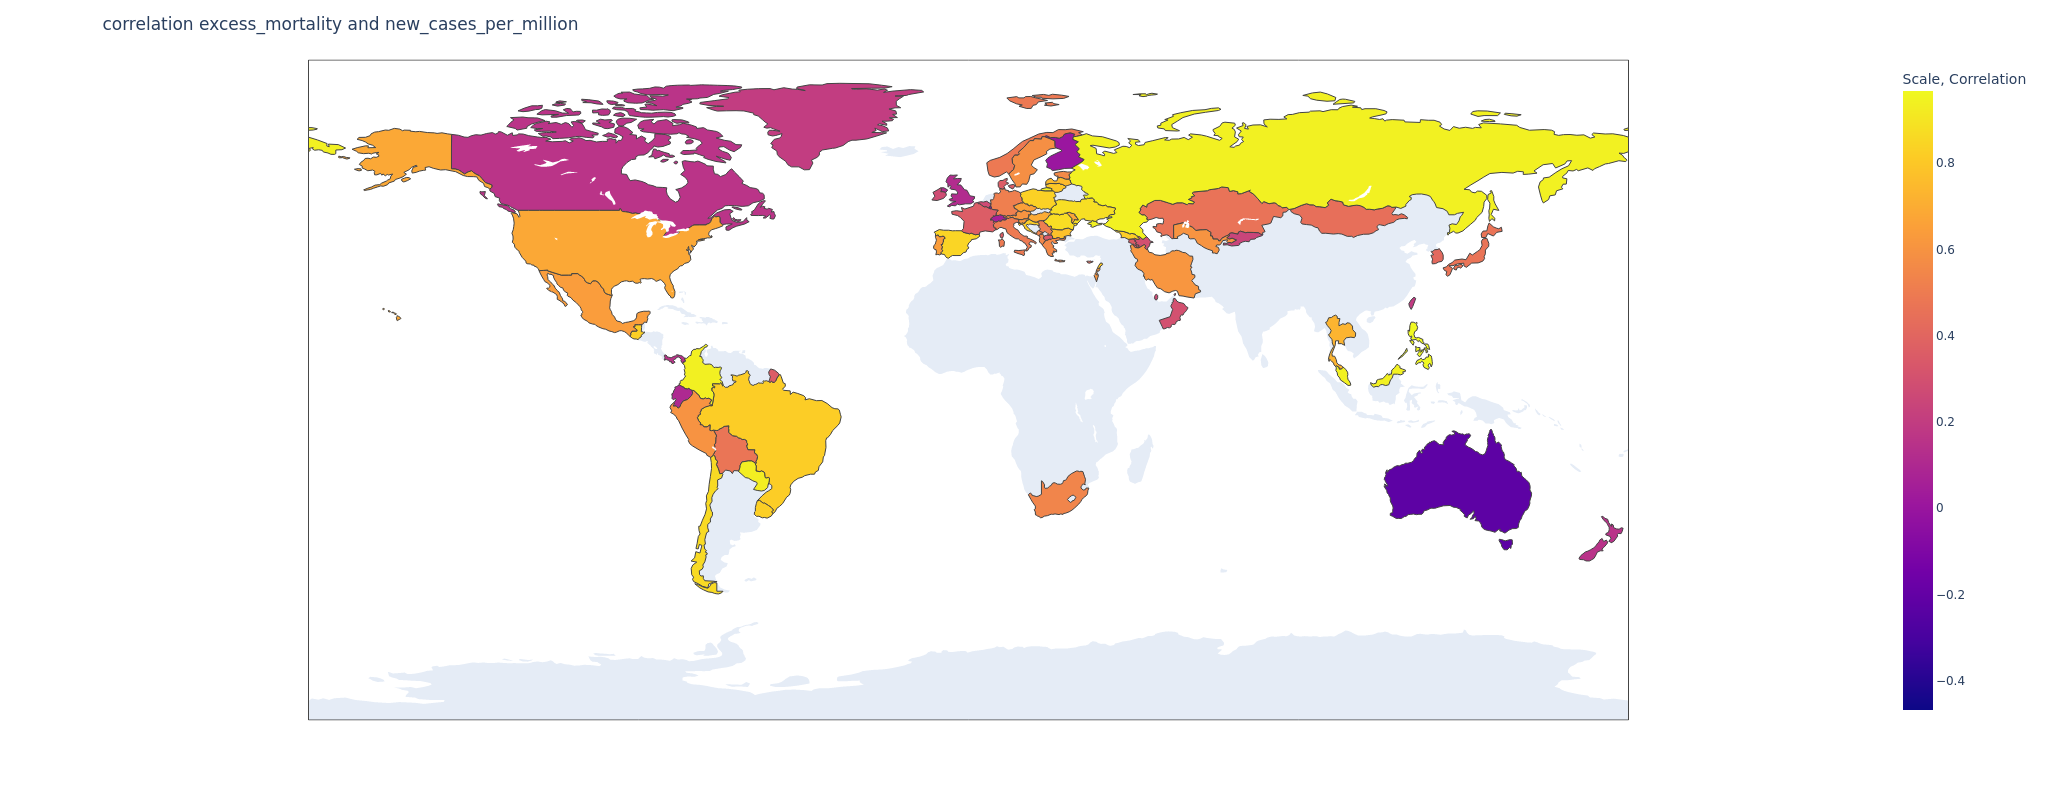

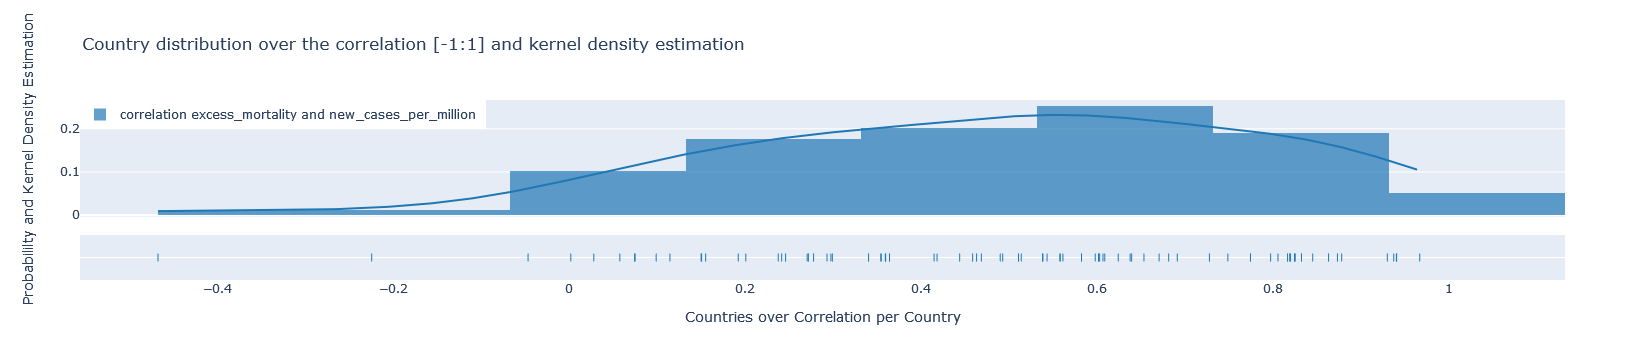

In [6]:
for metric in ['total_vaccinations_per_hundred'
               , 'people_vaccinated_per_hundred'
               , 'people_fully_vaccinated_per_hundred'
               , 'total_boosters_per_hundred'
               , 'new_cases_per_million' ]:
    
    country_corr=dfc.groupby('iso_code')[
        ['excess_mortality', metric]
                   ].corr().unstack().iloc[:,1].reset_index()
    
    colname = 'correlation excess_mortality and ' + metric

    country_corr.columns=['iso_code', colname]
    
    fig = px.choropleth (
        country_corr,
        locationmode = 'ISO-3',
        locations = 'iso_code',
        color = colname,
    )
    fig.update_traces(
        showlegend=False
        , selector=dict(type='choropleth'))
    fig.update_layout(
        width=2048,
        height=800,
        title_text=colname,
        geo=dict( showcoastlines=False,),
        coloraxis_colorbar=dict( title='Scale, Correlation',),
        )
    fig.show('png')   
    
    fig=ff.create_distplot(
        [country_corr.dropna()[colname]]
        , [colname]
        , bin_size=.2
        , histnorm = 'probability'
    )
    fig.update_layout(
        title_text='Country distribution over the correlation [-1:1] and kernel density estimation'
        , xaxis_title="Countries over Correlation per Country"
        , yaxis_title="Probabililty and Kernel Density Estimation"
        , legend_x=0 
    )
    fig.show()

## Interpolated Data For Visual Control

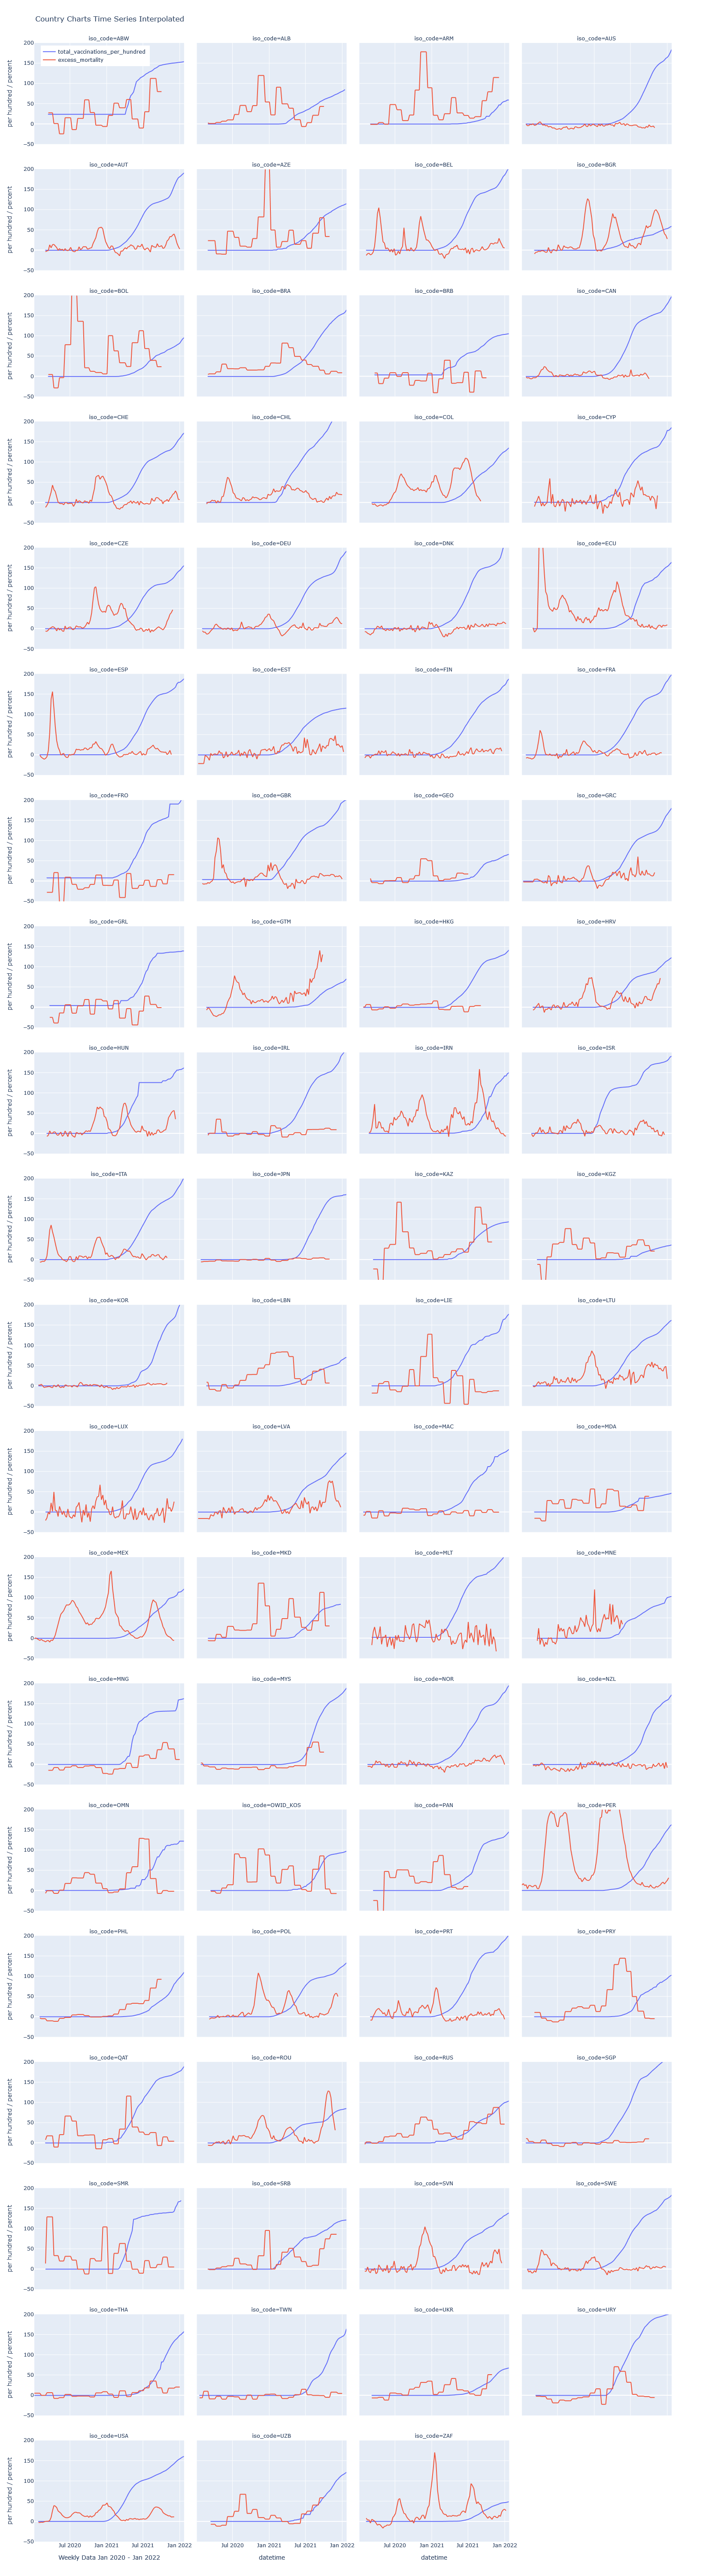

In [7]:
fig = px.line(dfi,    
              x='datetime',
              y=['total_vaccinations_per_hundred','excess_mortality'],
              facet_col='iso_code', 
              category_orders={'iso_code':sorted(countries_worth_looking_at)},
              facet_col_wrap=4,
              facet_row_spacing=0.01,
              height=6000, width=800, # change to fit your output media 
              labels={
                  "value": "per hundred / percent",
                  "variable": "",
              },
              title="Country Charts Time Series Interpolated",              
             )

fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.999,
        xanchor="left",
        x=0.01
    ),
    xaxis_title="Weekly Data Jan 2020 - Jan 2022"             
)

fig.update_yaxes(range=[-50, 200])

fig.show() # we can't use 'png' here in JupyterLab as the charts get scrambled, a plotly bug?

## Obligatory XKCD parabole
![Obligatory XKCD parabole](https://imgs.xkcd.com/comics/cell_phones.png)

Permanent link to this comic: https://xkcd.com/925/

# Copyright and Getting the Data

Copyright 2021 Abbrivia GmbH https://www.abbrivia.com CC-BY (By Attribution) 4.0 https://creativecommons.org/licenses/by/4.0/legalcode
**Reuse our work freely!**

All visualizations, and code produced in this notebook are completely open access under the Creative Commons BY license. You have the permission to use, distribute, and reproduce these in any medium, provided the source and authors are credited.

The data produced by third parties and made available by "Our World in Data" is subject to the license terms from the original third-party authors. Check the license of any third-party data before use and redistribution on 'https://ourworldindata.org/coronavirus' site (see below).

See the defintions and further discussion on the used dataset at the "Our World in Data" site  https://ourworldindata.org/covid-vaccinations

The data is taken specifically from https://covid.ourworldindata.org/data/owid-covid-data.xlsx file

Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]

We use Excel file because it contains the data format information in itself. If you want to run this more often consider manually downloading the data and sourcing it locally as shown in the next line (commented out).